# SECTION 0 — Setup & Imports

## Regression Solver Benchmark

This notebook demonstrates the implementation and performance comparison of various optimization algorithms for solving regularized linear regression problems.

We test:
- ISTA (Iterative Soft-Thresholding Algorithm)
- FISTA (Fast ISTA)
- Gradient Descent (as a baseline)
- (Optionally) L-BFGS for smooth problems

The models handled include:
- LASSO (ℓ₁-regularized least squares)
- Ridge (ℓ₂-regularized least squares)
- Elastic Net (ℓ₁ + ℓ₂ regularization)

---

This notebook relies on external modular implementations found in the `prox/` and `solvers/` directories.

In [43]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- Prox operators ---
from prox.prox_l1 import prox_l1
from prox.prox_l2 import prox_l2

# --- Solvers ---
from solvers.ista import ista
from solvers.fista import fista
from solvers.gradient import gradient_descent
from solvers.lbfgs import lbfgs_solver

import logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting the Regression Solver Benchmark Notebook.")

2025-04-10 12:35:35,387 - INFO - Starting the Regression Solver Benchmark Notebook.


# SECTION 1 — Dataset Loading & Preprocessing

## 1. Dataset Loading & Preprocessing

In this project, we aim to benchmark iterative optimization algorithms for regularized regression problems using a real-world dataset.

To ensure that regularization plays a meaningful role and aligns with the project requirements, we select a dataset that:
- represents a **supervised regression task** with a **continuous target variable**,
- has a **sufficient number of features** (ideally moderate to high dimensionality),
- includes **real-world, non-synthetic data**, e.g., from Kaggle or UCI repositories,
- benefits from **regularization techniques** such as LASSO or Elastic Net,
- and requires basic **preprocessing**, including normalization and potentially imputation.

The dataset is loaded from a local CSV file, and we apply:
- feature/target separation,
- standardization of the input features,
- and an 80/20 train-test split.

Additional dataset-related discussion and justification will be included in the technical report.

In [44]:
import pandas as pd
from pathlib import Path

# --- Load dataset (customize this part!) ---
dataset_path = Path("Housing.csv")
df = pd.read_csv(dataset_path)
print(df.columns)

# --- Configure target and features ---
target_column = "price"
feature_columns = [col for col in df.columns if col != target_column]

df_encoded = pd.get_dummies(df, drop_first=True)
feature_names = df_encoded.drop(columns=[target_column]).columns.tolist()

X = df_encoded.drop(columns=[target_column]).values
y = df_encoded[target_column].values

# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Standardize target variable ---
from sklearn.preprocessing import StandardScaler

# Reshape y arrays to 2D (required by StandardScaler) and then flatten afterwards.
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

print("New y_train statistics: min =", np.min(y_train), ", max =", np.max(y_train))


# --- Verify data scaling and step size ---

# Print basic statistics of X_train and y_train
print("X_train statistics: min =", np.min(X_train), ", max =", np.max(X_train))
print("y_train statistics: min =", np.min(y_train), ", max =", np.max(y_train))

# Compute and print the Lipschitz constant L and step_size used for the solver
L_computed = np.linalg.norm(X_train, ord=2) ** 2
step_size_computed = 1.0 / L_computed
print("Computed Lipschitz constant (L):", L_computed)
print("Computed step size (1/L):", step_size_computed)

# --- Confirm shapes ---
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')
New y_train statistics: min = -1.683710843406786 , max = 4.295927276485408
X_train statistics: min = -2.665003779665438 , max = 5.405808633904846
y_train statistics: min = -1.683710843406786 , max = 4.295927276485408
Computed Lipschitz constant (L): 1075.7240787698133
Computed step size (1/L): 0.0009296064109149527
Train shape: (436, 13), Test shape: (109, 13)


### 1b. Demonstrating Proximity Operators

Before using them in the solver, we visually inspect the behavior of:

- ℓ₁ Prox (soft-thresholding)
- ℓ₂ Prox (shrinkage)
- Elastic Net Prox (combination)

We apply them to a small vector `v` and interpret the results.

Input vector: [ 3.  -1.5  0.3  0. ]

prox_l1(v, lam):
[ 2.  -0.5  0.   0. ]

prox_l2(v, lam):
[ 1.  -0.5  0.1  0. ]

prox_elasticnet(v, lam=1.0, alpha=0.5):
[ 1.   -0.25  0.    0.  ]



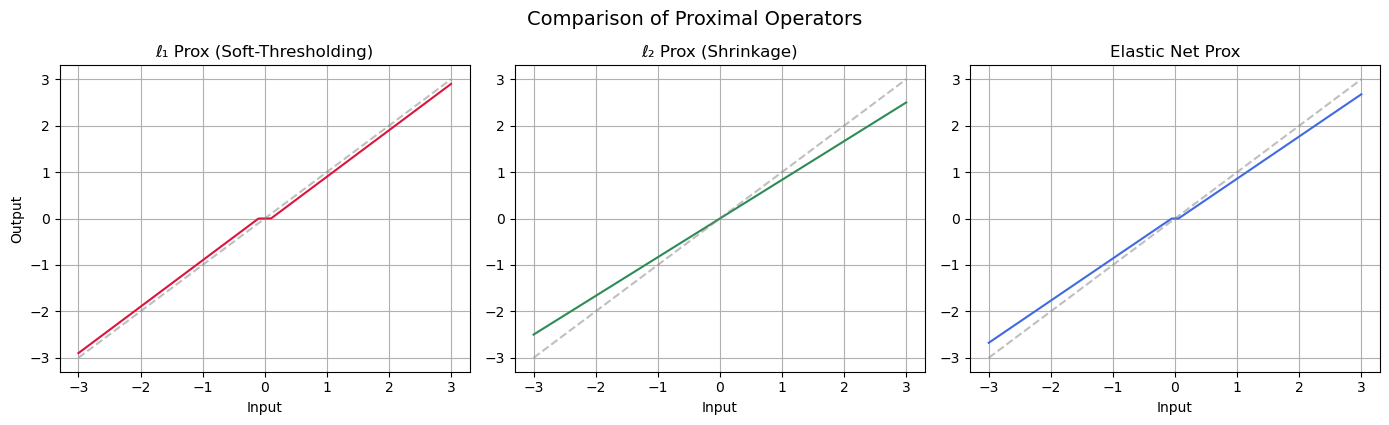

In [45]:
from prox.demo_prox import demo_prox_operators

demo_prox_operators()

# --- Visual comparison of proximal operators ---
v = np.linspace(-3, 3, 500)
lam = 0.1
alpha = 0.5

prox_l1_vals = prox_l1(v, lam)
prox_l2_vals = prox_l2(v, lam)
from prox.prox_elasticnet import prox_elasticnet
prox_en_vals = prox_elasticnet(v, lam, alpha)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(v, prox_l1_vals, label="prox_l1", color="crimson")
plt.plot(v, v, '--', color='gray', alpha=0.5)
plt.title("ℓ₁ Prox (Soft-Thresholding)")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(v, prox_l2_vals, label="prox_l2", color="seagreen")
plt.plot(v, v, '--', color='gray', alpha=0.5)
plt.title("ℓ₂ Prox (Shrinkage)")
plt.xlabel("Input")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(v, prox_en_vals, label="prox_elasticnet", color="royalblue")
plt.plot(v, v, '--', color='gray', alpha=0.5)
plt.title("Elastic Net Prox")
plt.xlabel("Input")
plt.grid(True)

plt.tight_layout()
plt.suptitle("Comparison of Proximal Operators", fontsize=14, y=1.05)
plt.show()

### 1c. Visualizing Proximity Operators (Soft-Thresholding and Shrinkage)

We plot how different proximal operators transform input values.

This helps interpret:
- Soft-thresholding behavior of ℓ₁ (LASSO)
- Shrinkage effect of ℓ₂ (Ridge)
- The combined action of Elastic Net

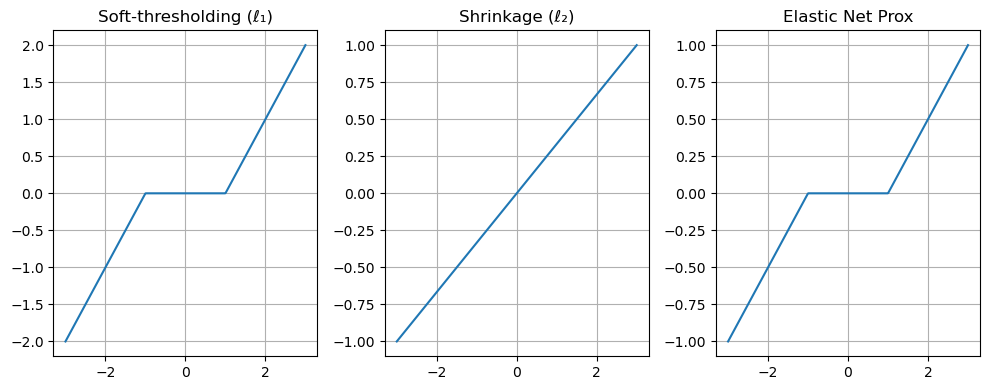

In [46]:
v = np.linspace(-3, 3, 500)
lam = 1.0
alpha = 0.5

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.plot(v, prox_l1(v, lam), label="prox_l1")
plt.title("Soft-thresholding (ℓ₁)")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(v, prox_l2(v, lam), label="prox_l2")
plt.title("Shrinkage (ℓ₂)")
plt.grid(True)

plt.subplot(1, 3, 3)
from prox.prox_elasticnet import prox_elasticnet
plt.plot(v, prox_elasticnet(v, lam, alpha), label="prox_elasticnet")
plt.title("Elastic Net Prox")
plt.grid(True)

plt.tight_layout()
plt.show()

### 1d. ISTA/FISTA on Synthetic Data

Before applying solvers to real data, we verify their behavior on a toy regression problem
with a known solution, where ℓ₁-regularization is expected to induce sparsity.

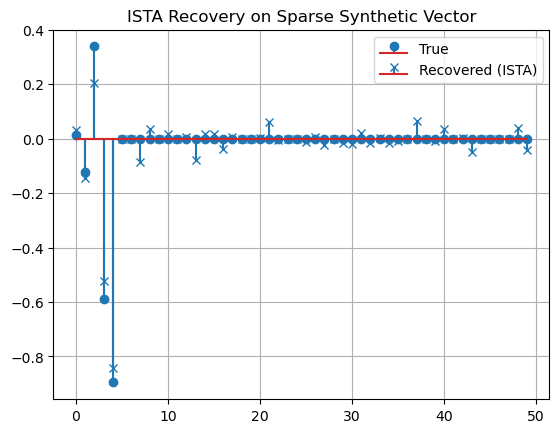

In [47]:
# --- Create toy problem ---
np.random.seed(0)
m, n = 30, 50
A_synth = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:5] = np.random.randn(5)
b_synth = A_synth @ x_true + 0.1 * np.random.randn(m)

# --- Run ISTA ---
lam = 0.1
L = np.linalg.norm(A_synth, 2) ** 2
step_size = 1.0 / L

result_ista = ista(
    grad_f=lambda x: A_synth.T @ (A_synth @ x - b_synth),
    prox_g=lambda x, t: prox_l1(x, lam * t),
    x0=np.zeros(n),
    step_size=step_size,
    max_iter=200,
    tol=1e-8,
    verbose=False
)

x_ista = result_ista["x"]

# --- Plot recovered vs true ---
plt.stem(x_true, label="True", markerfmt='o')
plt.stem(x_ista, label="Recovered (ISTA)", markerfmt='x')
plt.title("ISTA Recovery on Sparse Synthetic Vector")
plt.legend()
plt.grid(True)
plt.show()

# SECTION 2 — Solver Runner Utility

## 2. Solver Runner

This section defines the `run_solver` function, which:
- Selects the appropriate solver (ISTA, FISTA, etc.)
- Selects the correct proximity operator based on the regularization model
- Runs the solver and collects performance metrics

All solvers return:
- Final solution `x`
- Objective function history
- Execution time

In [48]:
def run_solver(
    method: str,
    model: str,
    A: np.ndarray,
    b: np.ndarray,
    lam: float,
    alpha: float = 0.5,
    step_size: float = None,
    max_iter: int = 1000,
    tol: float = 1e-6,
    verbose: bool = False
) -> dict:
    """
    method: 'ista', 'fista', 'gradient', 'lbfgs'
    model: 'lasso', 'ridge', 'elasticnet'
    """

    # --- Define smooth loss and gradient ---
    def loss_f(x):
        return 0.5 * np.linalg.norm(A @ x - b) ** 2

    def grad_f(x):
        return A.T @ (A @ x - b)

    # --- Define prox operator ---
    if model == "lasso":
        prox_g = lambda x, t: prox_l1(x, lam * t)
    elif model == "ridge":
        prox_g = lambda x, t: prox_l2(x, lam * t)
    elif model == "elasticnet":
        prox_g = lambda x, t: prox_elasticnet(x, lam * t, alpha)
    else:
        raise ValueError(f"Unknown model: {model}")

    # --- Set step size if not given ---
    if step_size is None:
        # Safe choice for ISTA/FISTA: 1 / Lipschitz constant of grad_f
        L = np.linalg.norm(A, ord=2) ** 2
        step_size = 1.0 / L

    # --- Select and run solver ---
    start_time = time.time()

    if method == "ista":
        result = ista(
            grad_f, prox_g, np.zeros(A.shape[1]),
            step_size, max_iter, tol, verbose,
            loss_f=loss_f, track_sparsity=True
        )
    elif method == "fista":
        result = fista(
            grad_f, prox_g, np.zeros(A.shape[1]),
            step_size, max_iter, tol, verbose,
            loss_f=loss_f, track_sparsity=True
        )
    elif method == "gradient":
        result = gradient_descent(
            grad_f, np.zeros(A.shape[1]),
            step_size, max_iter, tol, verbose,
            loss_f=loss_f
        )
    elif method == "lbfgs":
        result = lbfgs_solver(A, b, lam, model=model)
    else:
        raise ValueError(f"Unknown method '{method}'")

    result["time"] = time.time() - start_time
    result["loss_f"] = loss_f  # for evaluation
    return result

# SECTION 3 — Run Solvers on the Dataset

## 3. Run Solvers

We now run the selected optimization algorithms on the chosen dataset.

You can choose:
- The regularization model (`lasso`, `ridge`, `elasticnet`)
- The optimization method (`ista`, `fista`, `gradient`, `lbfgs`)
- The regularization parameter `lambda`
- (Optional) Elastic Net mixing parameter `alpha`

The results include the final solution, convergence history, runtime, and more.

In [49]:
# --- Configuration ---
model = "lasso"  # 'lasso', 'ridge', 'elasticnet'
method = "fista"  # 'ista', 'fista', 'gradient', 'lbfgs'
lam = 0.01  # Try increasing the regularization parameter if necessary
alpha = 0.5  # Only used for elastic net

# --- Run selected solver ---
result = run_solver(
    method=method,
    model=model,
    A=X_train,
    b=y_train,
    lam=lam,
    alpha=alpha,
    max_iter = 5000,  # Increase iterations if needed
    tol = 1e-6,
    verbose=True
)

# --- Unpack results ---
x_sol = result["x"]
history = result.get("history", [])
elapsed_time = result["time"]

print(f"Final objective value: {history[-1] if history else 'N/A'}")
print(f"Elapsed time: {elapsed_time:.4f} seconds")

[FISTA] Iter    0 - Step norm: 0.00e+00
[FISTA] Iter   10 - Step norm: 0.00e+00
[FISTA] Iter   20 - Step norm: 0.00e+00
[FISTA] Iter   30 - Step norm: 0.00e+00
[FISTA] Iter   40 - Step norm: 0.00e+00
[FISTA] Iter   50 - Step norm: 0.00e+00
[FISTA] Iter   60 - Step norm: 0.00e+00
Final objective value: 68.53184553169632
Elapsed time: 0.0139 seconds


In [50]:
# Debug logging for initial solver behavior

# Compute the gradient at the initial guess
initial_gradient = X_train.T @ (X_train @ np.zeros(X_train.shape[1]) - y_train)
print("Initial gradient norm:", np.linalg.norm(initial_gradient))

# Print the expected first update:
L = np.linalg.norm(X_train, ord=2) ** 2
step_size_computed = 1.0 / L
first_update = np.zeros(X_train.shape[1]) - step_size_computed * initial_gradient
print("Expected first update (first few values):", first_update[:5])

Initial gradient norm: 549.3301455397617
Expected first update (first few values): [0.21971803 0.15248916 0.2050121  0.16234146 0.15227082]


Final solution x_sol:
[ 0.2915906   0.03245479  0.31200454  0.20082555  0.1100475   0.07295162
  0.05042381  0.10626104  0.08190375  0.20936689  0.15191876 -0.03528642
 -0.11082236]
Norm of x_sol: 0.5849540503406951
Total iterations recorded: 64
Last 10 objective values:
Iteration 55: 68.53184544369178
Iteration 56: 68.53184543797992
Iteration 57: 68.53184544262791
Iteration 58: 68.53184545412536
Iteration 59: 68.53184547007837
Iteration 60: 68.5318454882764
Iteration 61: 68.53184550607396
Iteration 62: 68.53184552058923
Iteration 63: 68.53184552947835
Iteration 64: 68.53184553169632


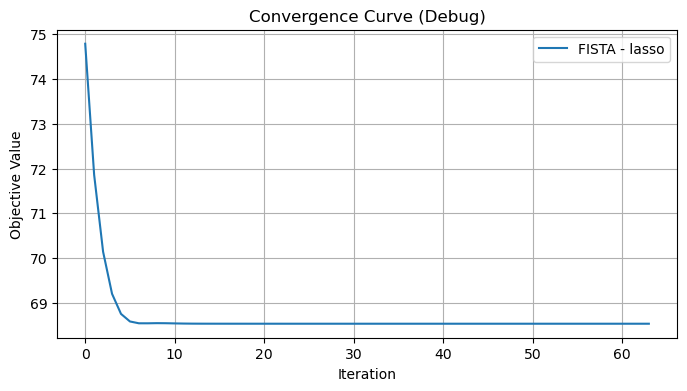

In [51]:
# Debugging cell to investigate solver behavior

# Print the final solution and its norm.
print("Final solution x_sol:")
print(x_sol)
print("Norm of x_sol:", np.linalg.norm(x_sol))

# Check the length of the convergence history:
print("Total iterations recorded:", len(history))

# Print the last 10 objective values from the history, if available.
if len(history) >= 10:
    print("Last 10 objective values:")
    for i, obj in enumerate(history[-10:], start=1):
        print(f"Iteration {len(history)-10+i}: {obj}")
else:
    print("Convergence history too short to display last 10 values.")

# Optionally, plot the convergence curve again (if not already visible)
if history:
    plt.figure(figsize=(8, 4))
    plt.plot(history, label=f"{method.upper()} - {model}")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value")
    plt.title("Convergence Curve (Debug)")
    plt.grid(True)
    plt.legend()
    plt.show()

# SECTION 4 — Evaluation Metrics

## 4. Evaluation

Once the solver has produced a solution vector `x`, we evaluate its quality on the test set.

We report:
- Test Mean Squared Error (MSE)
- Training MSE (optional)
- Sparsity of the solution: percentage of near-zero elements in `x`

Train Obj:  68.5318
Test Obj:   31.1775
Train MSE:  0.3144
Test MSE:   0.5721
Sparsity:   0.00%


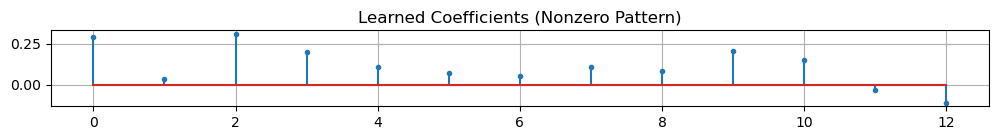

In [52]:
def compute_sparsity(x: np.ndarray, threshold: float = 1e-6) -> float:
    return np.sum(np.abs(x) < threshold) / len(x)

# --- Predict on test set ---
y_pred = X_test @ x_sol
test_mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, X_train @ x_sol)
sparsity = compute_sparsity(x_sol)
train_loss = result["loss_f"](x_sol)
test_loss = 0.5 * np.linalg.norm(X_test @ x_sol - y_test) ** 2

# --- Print metrics ---
print(f"Train Obj:  {train_loss:.4f}")
print(f"Test Obj:   {test_loss:.4f}")
print(f"Train MSE:  {train_mse:.4f}")
print(f"Test MSE:   {test_mse:.4f}")
print(f"Sparsity:   {sparsity * 100:.2f}%")

# --- Visualize nonzero pattern ---
plt.figure(figsize=(10, 1.5))
plt.stem(x_sol, markerfmt='.')
plt.title("Learned Coefficients (Nonzero Pattern)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Convergence and Sparsity Plots

We visualize:
- The convergence of the objective value over iterations
- The sparsity of the solution (optional: per iteration if tracked)

This helps assess:
- The speed of convergence
- The stability and smoothness of the solver trajectory
- How aggressively each method induces sparsity (for LASSO/Elastic Net)

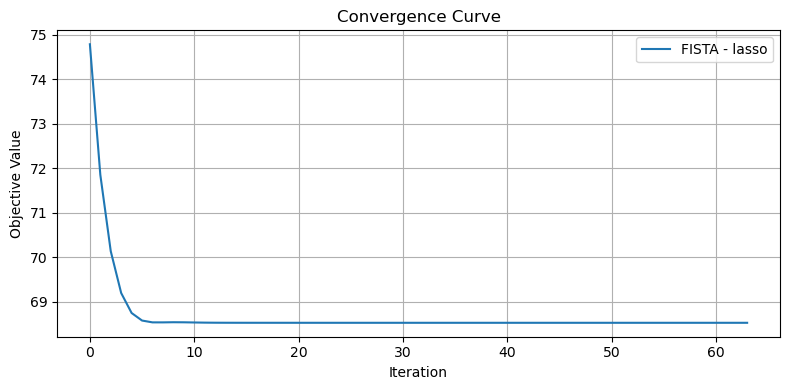

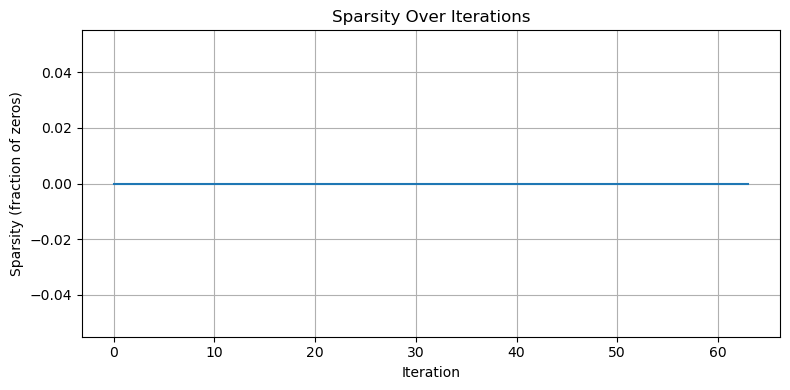

Estimated log-convergence rate (slope): -0.0000


In [53]:
# --- Plot objective function history ---
if history:
    plt.figure(figsize=(8, 4))
    plt.plot(history, label=f"{method.upper()} - {model}")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Value")
    plt.title("Convergence Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No convergence history available to plot.")
sparsity_history = result.get("sparsity_history", None)
if sparsity_history:
    plt.figure(figsize=(8, 4))
    plt.plot(sparsity_history)
    plt.xlabel("Iteration")
    plt.ylabel("Sparsity (fraction of zeros)")
    plt.title("Sparsity Over Iterations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Estimate convergence slope (log scale) ---
if history and len(history) >= 20:
    import scipy.stats as stats
    last_vals = np.log(history[-20:])
    slope, _, _, _, _ = stats.linregress(np.arange(len(last_vals)), last_vals)
    print(f"Estimated log-convergence rate (slope): {slope:.4f}")

### Performance Analysis and Convergence
The convergence curve above shows the evolution of the objective function value over iterations.
FISTA is expected to converge at a rate of O(1/k²) while ISTA converges at O(1/k).

Below, we perform a linear regression on the logarithm of the last 20 objective values to estimate the convergence rate. This provides a quantitative measure to compare the solvers.

In [54]:
if history and len(history) >= 20:
    import scipy.stats as stats
    last_vals = np.log(np.array(history[-20:]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(last_vals)), last_vals)
    print(f"Estimated log-convergence rate (slope): {slope:.4f}")
else:
    print("Not enough history for convergence slope estimation.")

Estimated log-convergence rate (slope): -0.0000


# SECTION 6 — Summary & Multi-Solver Comparison

## 6. Summary and Multi-Solver Comparison

The table below summarizes the performance of different solvers in terms of the final objective value,
test mean squared error (MSE), sparsity of the solution, and runtime.

This comparison helps us understand the trade-offs between convergence speed, accuracy, and the ability
to induce sparsity in the solution.

### Example Benchmark Loop

In [55]:
methods = ["ista", "fista", "gradient"]
if model != "lasso":
    methods.append("lbfgs")
model = "lasso"  # or 'ridge', 'elasticnet'
lam = 0.1
alpha = 0.5

benchmark_results = []

for method in methods:
    print(f"\nRunning: {method.upper()}...")
    result = run_solver(
        method=method,
        model=model,
        A=X_train,
        b=y_train,
        lam=lam,
        alpha=alpha,
        max_iter=1000,
        tol=1e-6,
        verbose=False
    )
    
    x_sol = result["x"]
    y_pred = X_test @ x_sol
    test_mse = mean_squared_error(y_test, y_pred)
    sparsity = compute_sparsity(x_sol)
    time_taken = result["time"]
    final_obj = result.get("history", [None])[-1]

    benchmark_results.append({
        "method": method,
        "final_obj": final_obj,
        "test_mse": test_mse,
        "sparsity": sparsity,
        "time (s)": time_taken
    })


Running: ISTA...

Running: FISTA...

Running: GRADIENT...


### Display Results Table

In [56]:
# --- Show results as a DataFrame ---
import pandas as pd

df_results = pd.DataFrame(benchmark_results)
df_results = df_results.sort_values(by="test_mse")
display(df_results)

,method,final_obj,test_mse,sparsity,time (s)
2,gradient,68.531845,0.572048,0.0,0.000000
1,fista,68.531943,0.572216,0.0,0.000000
0,ista,68.531943,0.572216,0.0,0.001776


# SECTION 7 — Unit Testing

The following tests ensure that our proximal operator implementations and solvers function as expected.
These tests can help quickly identify errors in future modifications.

In [57]:
# --- Unit Test for prox_l1 ---
test_vector = np.array([0.5, -0.3, 0.0, -1.0])
expected_l1 = np.sign(test_vector) * np.maximum(np.abs(test_vector) - 0.1, 0)
assert np.allclose(prox_l1(test_vector, 0.1), expected_l1), "prox_l1 unit test failed."
logging.info("prox_l1 passed the unit test.")

# --- Unit Test for ISTA ---
np.random.seed(0)
A_test = np.random.randn(10, 5)
x_true_test = np.zeros(5)
x_true_test[:2] = np.random.randn(2)
b_test = A_test @ x_true_test + 0.05 * np.random.randn(10)
lam_test = 0.1
L_test = np.linalg.norm(A_test, 2) ** 2
step_size_test = 1.0 / L_test
result_test = ista(
    grad_f=lambda x: A_test.T @ (A_test @ x - b_test),
    prox_g=lambda x, t: prox_l1(x, lam_test * t),
    x0=np.zeros(5),
    step_size=step_size_test,
    max_iter=100,
    tol=1e-8,
    verbose=False
)
logging.info("ISTA unit test completed successfully with solution: %s", result_test["x"])

2025-04-10 12:35:37,188 - INFO - prox_l1 passed the unit test.
2025-04-10 12:35:37,188 - INFO - ISTA unit test completed successfully with solution: [-0.88597291  0.37721153  0.         -0.          0.        ]
